In [1]:
import random
from typing import List

import numpy as np
import einops
import matplotlib.pyplot as plt
import torch
from torchtyping import TensorType, patch_typeguard
from tqdm.notebook import tqdm

from hand import show_transformer, Transformer, show_activations, set_debug
from exos import EXOS

%load_ext autoreload
%autoreload 2

set_debug()

# Handmmade Transformers

This notebook showcases some of the work I've done on the *handmade transformers* projects.
Given a completion function, the goal is to manually find weights that make a GPT-2 like transformer performs the completion task.

I present here some of the models I've created with more or less explications.
I created models for the following tasks:
- **IfThenElse**: Given $XYZ$, predict $Y$ if $X = 1$ and $Z$ if $X = 0$. Implemented with 1 layer of 2 heads and a MLP. 
- **Reverse**: Take a string of the form $x_1\cdots x_n | x_n \cdots x_{i+1}$ and completes with $x_i$. Implemented with 2 layers of 1 head.
- **FirstChar**: Always output the first non-padding token of the input. Uses 2 layers of 1 head.

## IfThenElse

![Schema of a tranformer that performs IfThenElse](./images/if-then-else.png)

The tokens are just "0" and "1", which are embedded as $[1, 0]$ and $[0, 1]$ respectively.

The residual stream has the following structure:
- Dimension [0, 1] is the embedding of the input token.
- Dimension [2, 3, 4] is the position embedding.
- Dimension [5, 6] is the embedding of the condition (ie. first token).
- Dimension [7, 8] is the embedding of "other option" token (ie. 2nd or 3rd token).
- Dimension [9, 10] is the embedding of the output token.
We write $[t, pos, cond, other, out]$ 

Here the model uses two induction heads, in order to copy the other tokens
into the last token.
- Head 0 copies the condition to dimension [5, 6] of all tokens.
- Head 1 copies token 2 or 3 (for token 3 and 2 resp.) into dimension [7, 8].

The feedforward is a 2 layer MLP with ReLU activation. We focus on what happens to the
last (3rd) token, as it is the only one that influences the output. 
- The first layer shifts the copy of the token 2 & 3 (dims [0, 1, 7, 8]) by 10 or -10 depending on the condition, in such a way that the ReLU erases the copy of the token that should not be output. There is no bias here.
- The second layer combines the two copies (one of which being erased) to compute the correct output, and then shifts it back by -10 to compensate the previous shift

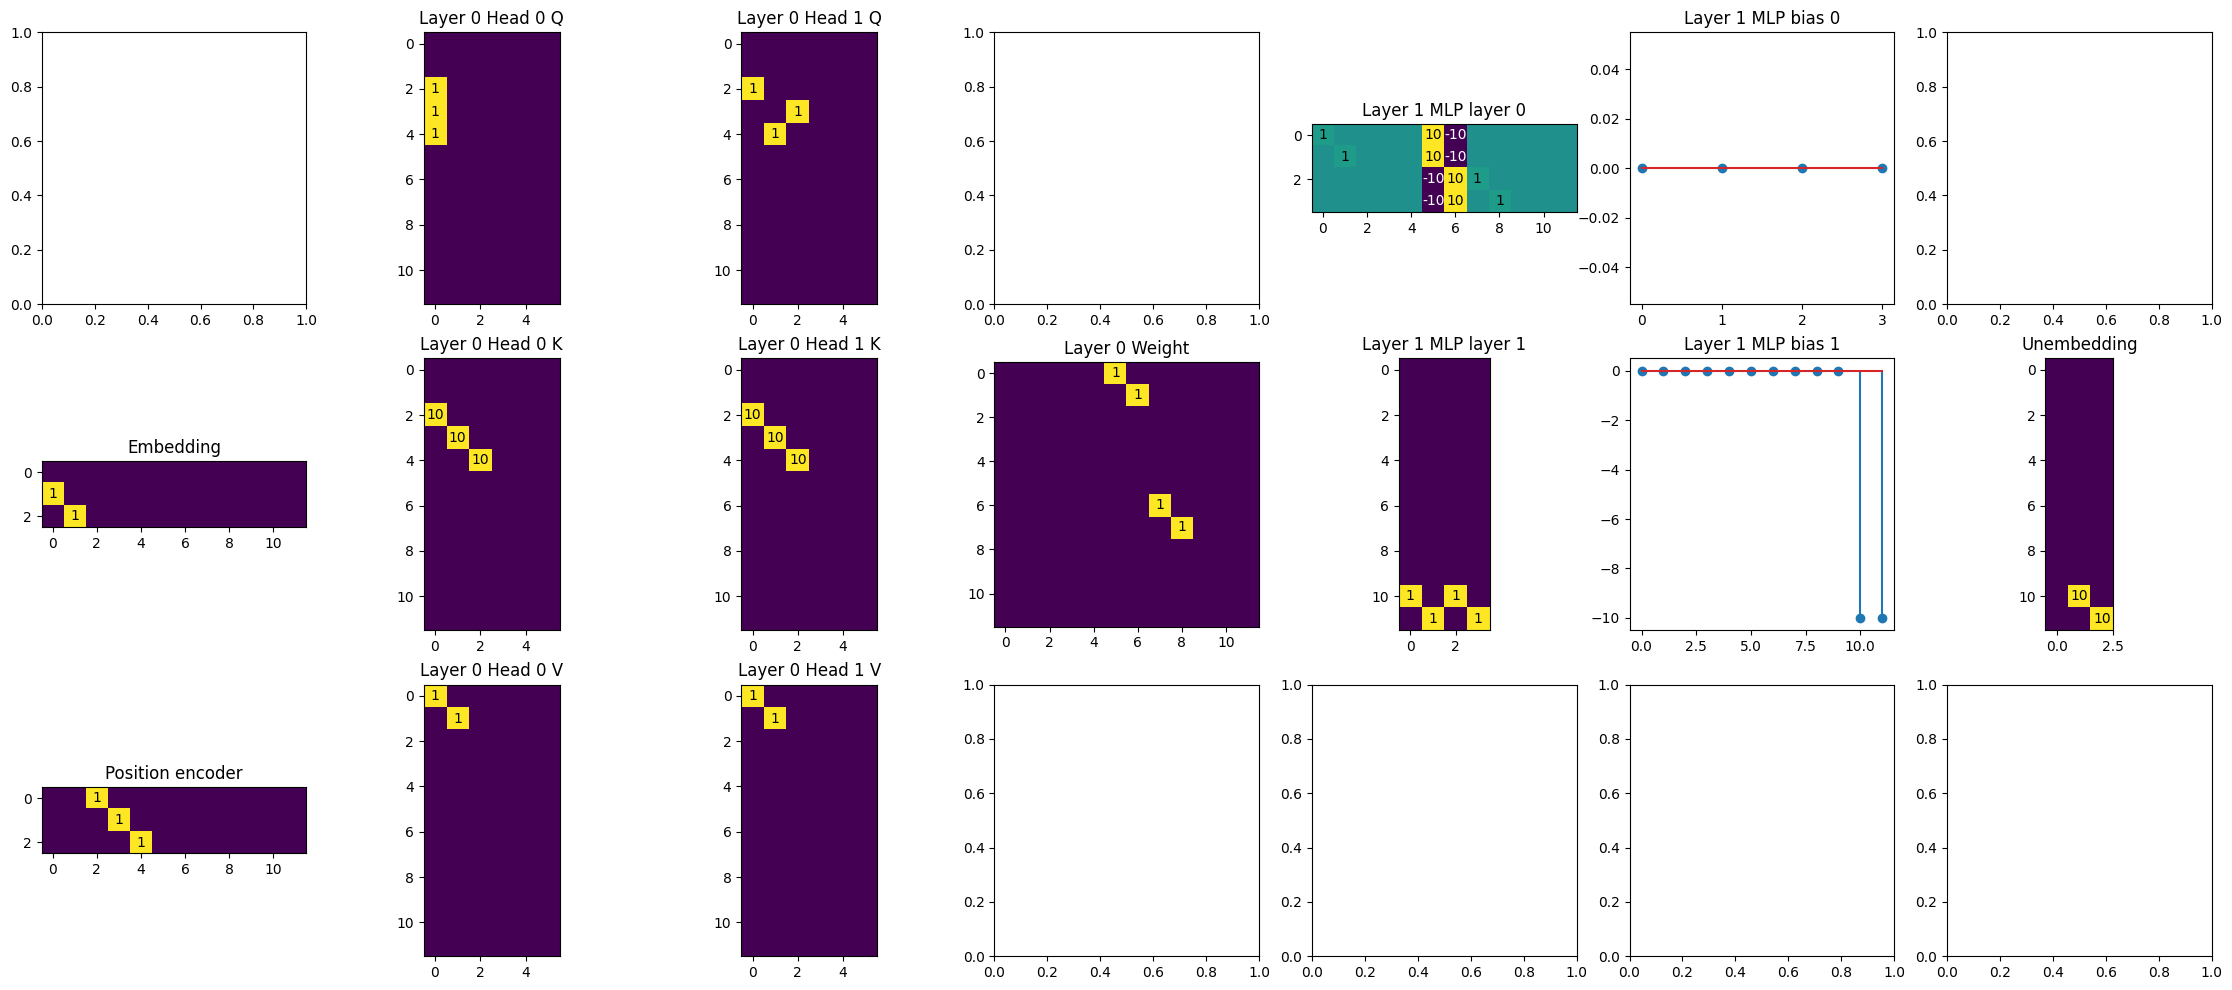

In [2]:
from exos import if_then_else
from solutions.if_then_else import if_then_else as if_then_else_sol

model = if_then_else_sol()
# if_then_else.test(model)

show_transformer(model)

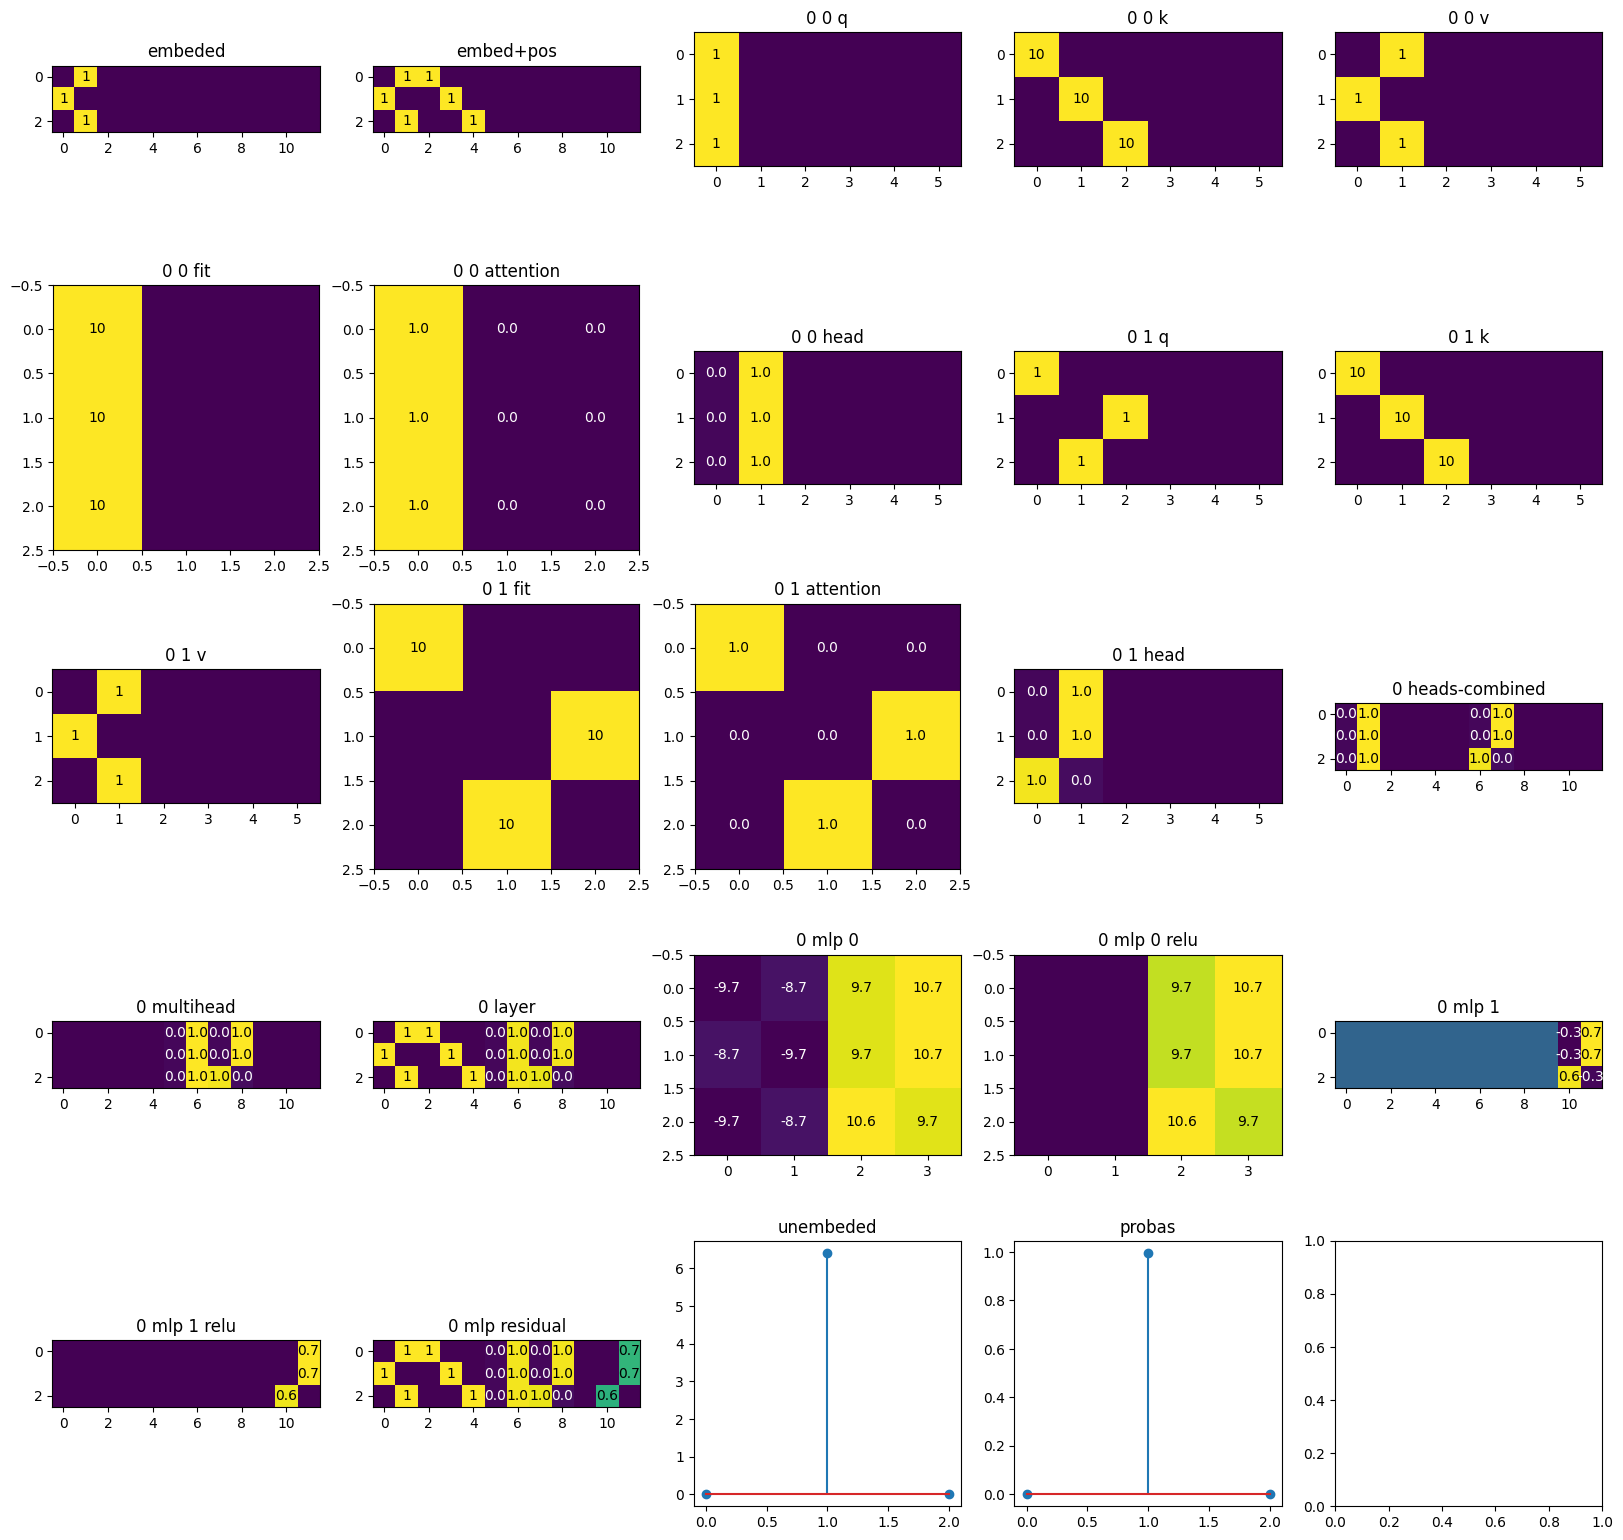

In [3]:
input_ = "101"
show_activations(model, if_then_else.tokenizer.encode([input_]))

## Reversing Text

![Schema of a transformer that reverses text](./images/reverse.png)

TODO: Explain how it works

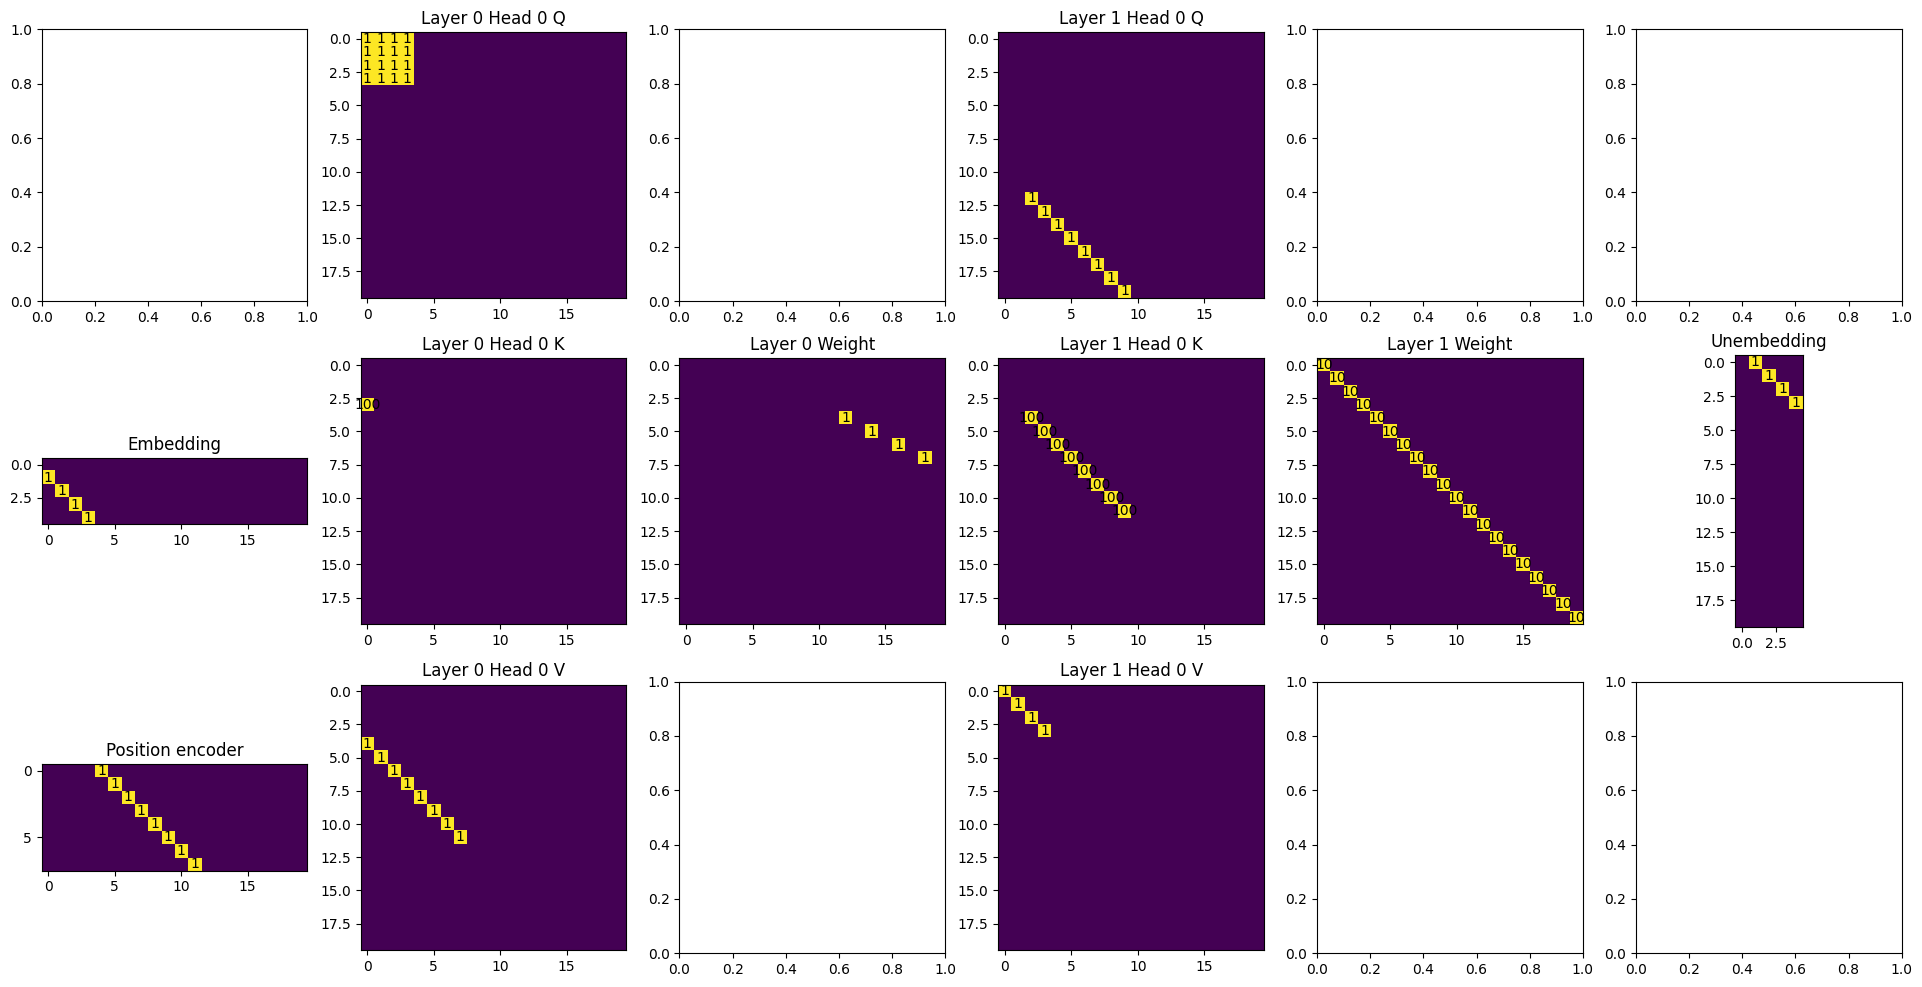

In [4]:
from exos import reverse
from solutions.reverse import reverse_better as reverse_sol

model = reverse_sol()
# reverse.test(model)

show_transformer(model)

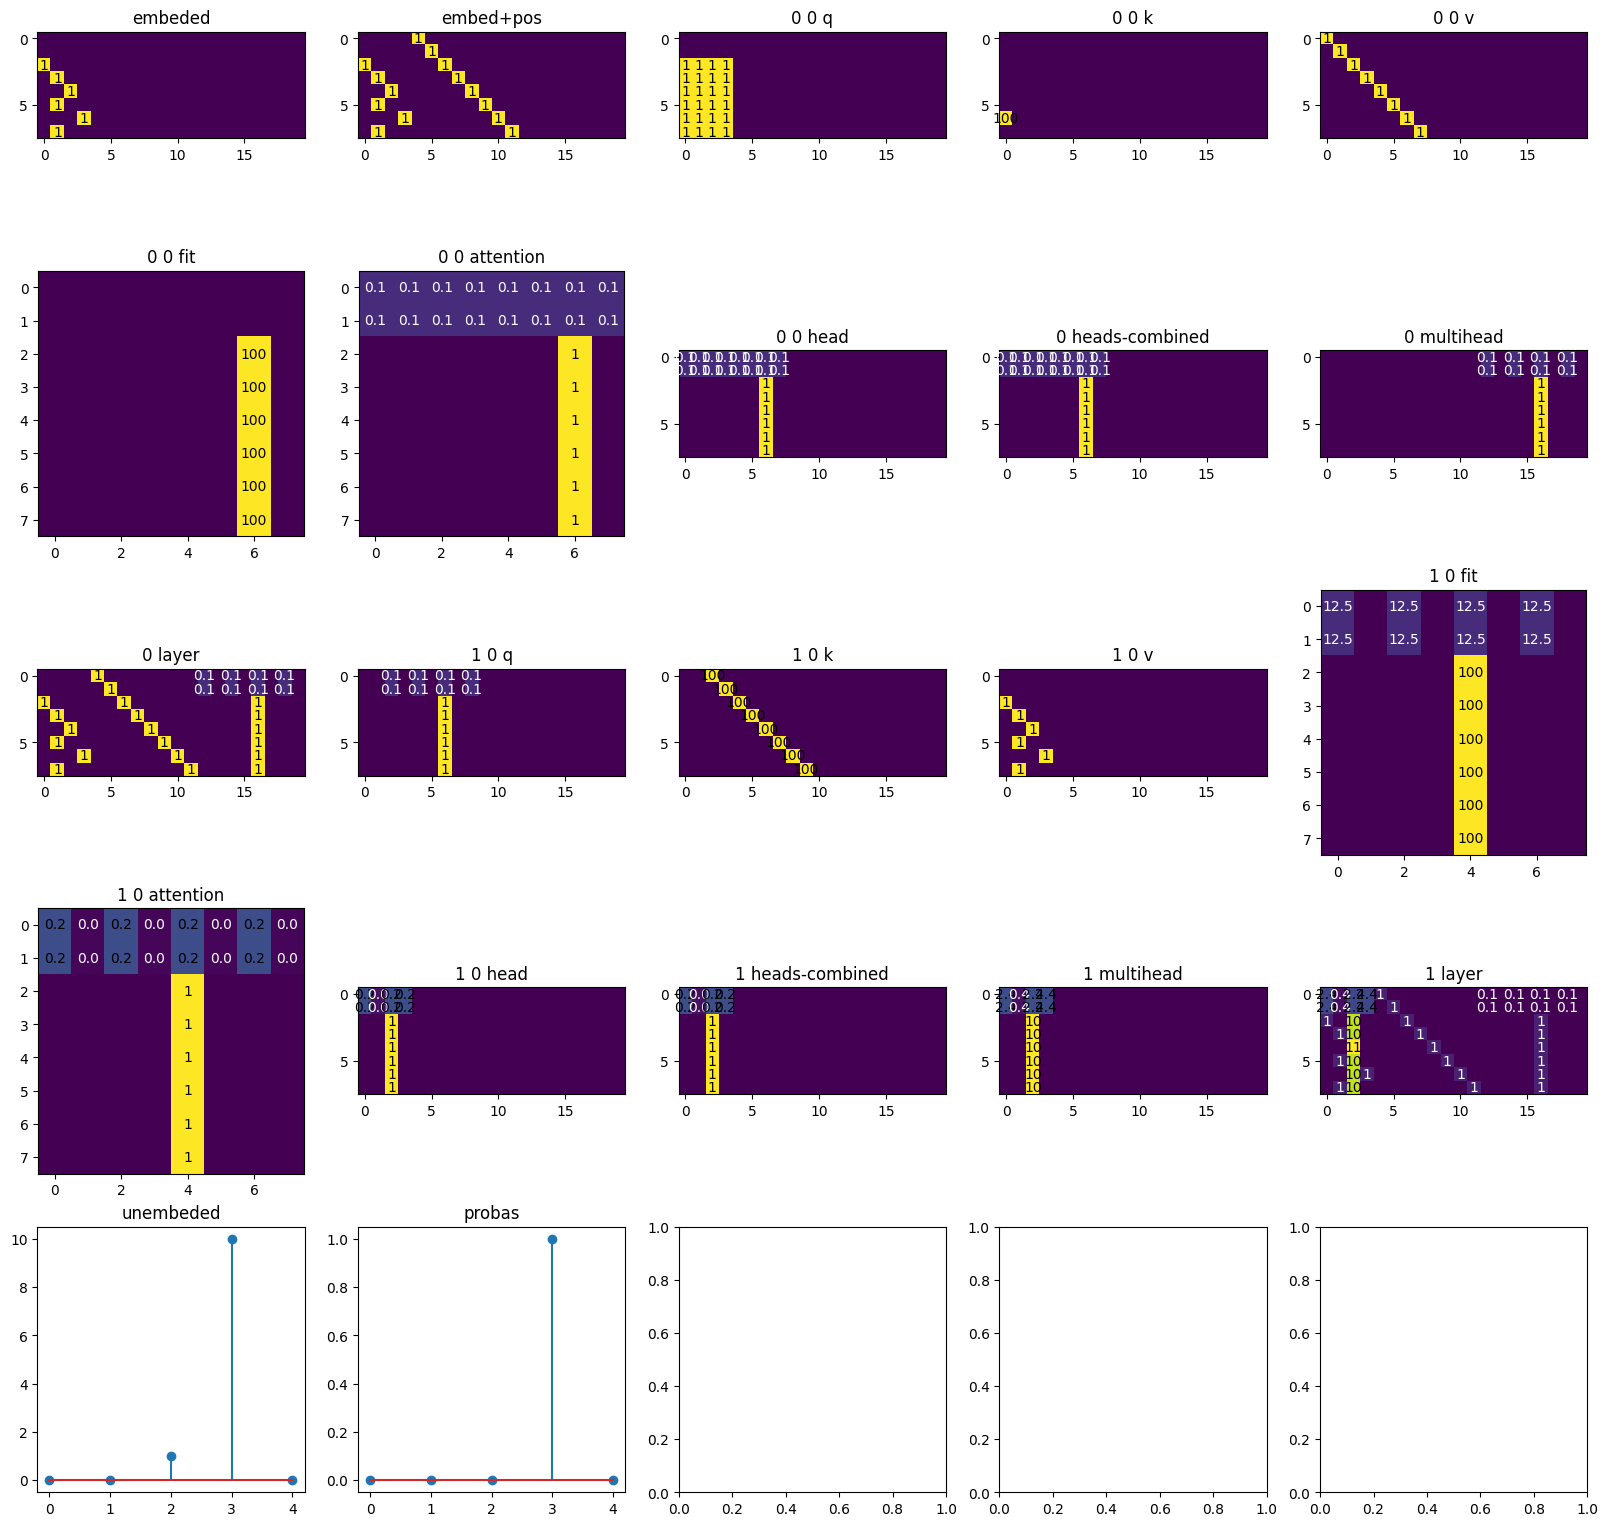

In [5]:
input_ = "abcb|b"  # max_len=8
show_activations(model, reverse.tokenizer.encode([input_]))